In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import pydeck as pdk
import matplotlib.pyplot as plt
import math
from tqdm import tqdm
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings(
    "ignore",
    message=".*A worker stopped while some jobs were given to the executor.*",
    category=UserWarning
)

## Load Data

In [2]:
# Load satellite data (CHL, PAR, SST)
print('loading data...')
chl_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/cmems satellite data original grid/cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D_CHL_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
par_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_PAR_globcolour_4km_daily_merged_L3m.nc')
sst_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-sst_glo_phy_my_l3s_P1D-m_multi-vars_126.95W-109.05W_22.05N-40.95N_1997-09-04-2020-01-25.nc')
kd490_ds = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-transp_my_l3-multi-4km_P1D_KD490_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
C_ds     = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-optics_my_l3-multi-4km_P1D_BBP_and_phyto_C_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
mld_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_mod_glo_phy_my_0.083deg_P1D-m_mlotst_127.00W-109.08W_22.08N-41.00N_1997-09-04-2020-01-25.nc')
chlc_ds  = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-optics_my_l3-multi-4km_P1D_CHLC_ratio_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
cdm_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-optics_my_l3-multi-4km_P1D_CDM_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
spm_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-transp_my_l3-multi-4km_P1D_SPM_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
phyt_ds  = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D_multi-vars_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
wind_ds  = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_wind_ds.nc')
no3_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_mod_glo_bgc_my_0.25deg_P1D-m_no3_127.00W-109.25W_22.25N-41.00N_0.51m_1997-09-04-2020-01-25.nc')
rrs_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-reflectance_my_l3-multi-4km_P1D_multi-vars_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')
zsd_ds   = xr.open_dataset('/Users/deliacarpenter/Desktop/Research/Primary Productivity CalCOFI/reindexed satellite data/reindexed_cmems_obs-oc_glo_bgc-transp_my_l3-multi-4km_P1D_ZSD_126.98W-109.02W_22.02N-40.98N_1997-09-04-2020-01-25.nc')

# Make sure everything is an xarray.Dataset (not DataArray)
datasets_to_merge = [
    chl_ds,
    par_ds,
    sst_ds,
    kd490_ds,
    C_ds,
    mld_ds,
    chlc_ds,
    cdm_ds,
    spm_ds,
    phyt_ds,
    wind_ds,
    no3_ds,
    rrs_ds,
    zsd_ds,
]

# Align datasets
print("aligning...")
aligned = xr.align(*datasets_to_merge, join="inner")  # or try "inner" for safety

# Merge all datasets
print('merging data...')
#satellite_ds = xr.merge(datasets_to_merge)
satellite_ds = xr.merge(list(aligned))

# Remove extra dimension from no3
satellite_ds['no3'] = satellite_ds['no3'].squeeze('depth').astype('float32')

loading data...
aligning...
merging data...


In [3]:
# Add MESD to satellite_ds

# Define representative diameters in microns for each group
d_pico = 0.7
d_nano = 5.0
d_micro = 50.0

# Pull the variables from the dataset
PICO = satellite_ds['PICO'].load()
NANO = satellite_ds['NANO'].load()
MICRO = satellite_ds['MICRO'].load()

# Compute biomass-weighted mean cell size (in microns)
numerator = (PICO * d_pico) + (NANO * d_nano) + (MICRO * d_micro)
denominator = PICO + NANO + MICRO

# Avoid divide-by-zero
MESD = xr.where(denominator > 0, numerator / denominator, np.nan)

# Assign to dataset
satellite_ds['MESD'] = MESD
satellite_ds['MESD'].attrs['units'] = 'µm'
satellite_ds['MESD'].attrs['long_name'] = 'Mean Estimated Spherical Diameter (biomass-weighted)'

del PICO, NANO, MICRO

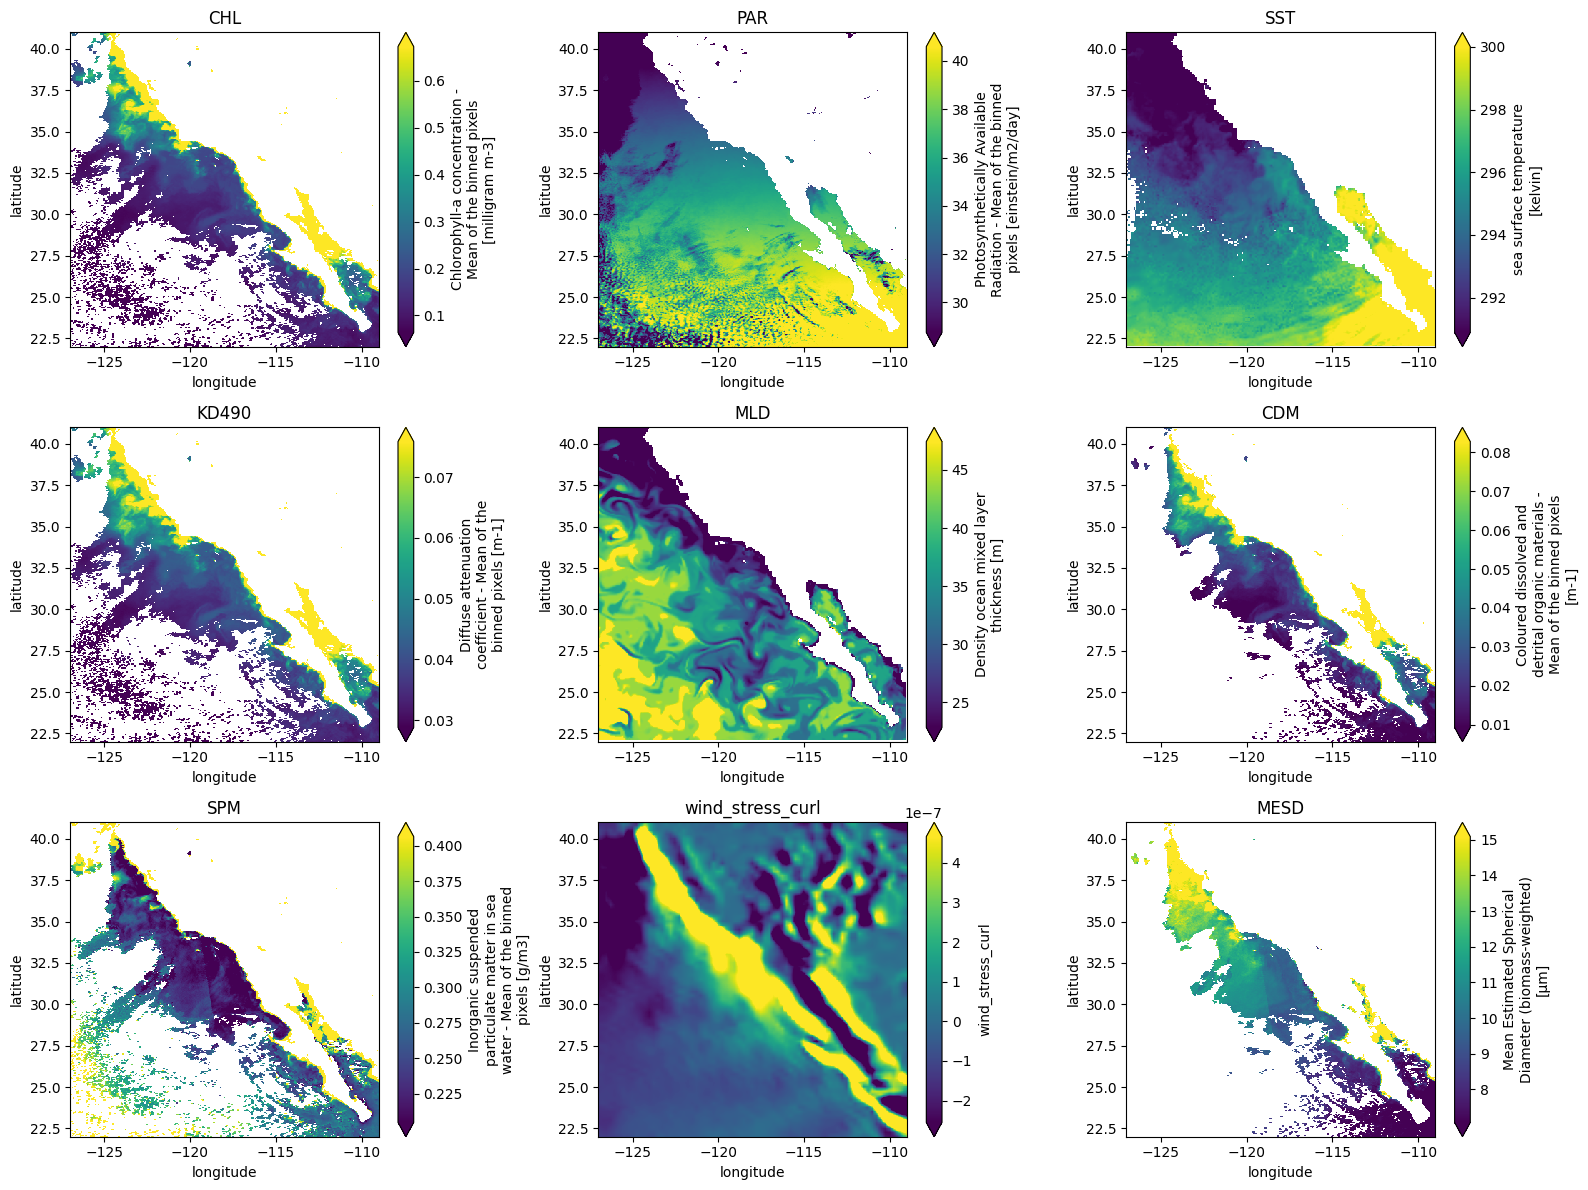

In [4]:
# Visualize one day of satellite data

# Select one day
date = '2015-10-30'
ds_day = satellite_ds.sel(time=date)

fig, axs = plt.subplots(3, 3, figsize=(16, 12))
axs = axs.ravel()

vars_to_plot = ['CHL', 'PAR', 'SST', 
                'KD490', 'MLD', 'CDM', 
                'SPM', 'wind_stress_curl', 'MESD']

for i, var in enumerate(vars_to_plot):
    data = ds_day[var]
    values = data.values.flatten()
    values = values[~np.isnan(values)]  # remove NaNs

    # Compute 10th and 90th percentiles
    vmin = np.percentile(values, 10)
    vmax = np.percentile(values, 90)

    data.plot(ax=axs[i], cmap='viridis', vmin=vmin, vmax=vmax)
    axs[i].set_title(var)

plt.tight_layout()
plt.show()

## Define functions

In [5]:
def calculate_grid_window(res_km, target_area_km2=729, valid_fraction=1/3):
    """
    Calculate the size of an n x n satellite pixel grid that best approximates a target spatial area, 
    and determine the minimum number of valid pixels required within that grid based on a valid fraction.
    """
    
    # Calculate the ideal grid size (in pixels) to match the target spatial area
    ideal_grid_size = math.sqrt(target_area_km2 / (res_km ** 2))
    
    # Round ideal size to nearest integer to get base grid size
    base_grid_size = round(ideal_grid_size)
    
    # Find nearest odd integer grid sizes: one just below or equal, and one just above
    odd_floor = base_grid_size if base_grid_size % 2 == 1 else base_grid_size - 1
    odd_ceil = odd_floor + 2  # Next odd number above odd_floor
    
    # Compute the actual spatial areas these two grid sizes represent
    area_floor = (odd_floor * res_km) ** 2
    area_ceil = (odd_ceil * res_km) ** 2
    
    # Choose the odd grid size with the area closest to the target area
    if abs(area_floor - target_area_km2) <= abs(area_ceil - target_area_km2):
        n = odd_floor
    else:
        n = odd_ceil
    
    # Calculate total number of pixels in the grid window
    total_pixels = n ** 2
    
    # Calculate the minimum number of valid pixels required, rounding to nearest integer
    min_valid_pixels = int(valid_fraction * total_pixels + 0.5)
    
    return n, min_valid_pixels

In [6]:
# Load Integrated NPP Data from CalCOFI Bottle Survey
npp = pd.read_csv('../data/CalCOFI_Integrated_NPP.csv', index_col=0)
npp = npp[['Date', 'Latitude', 'Longitude', 'Integrated_NPP']]
npp['Date'] = pd.to_datetime(npp['Date'])
npp = npp.sort_values(by='Date').reset_index(drop=True)
npp = npp[npp.Date >= '1997-09-04'].reset_index(drop=True)

# Precompute nearest lat/lon indices
ds_lats = satellite_ds.latitude.values
ds_lons = satellite_ds.longitude.values

npp['ilat'] = np.abs(ds_lats[:, None] - npp['Latitude'].values).argmin(axis=0)
npp['ilon'] = np.abs(ds_lons[:, None] - npp['Longitude'].values).argmin(axis=0)

# Clip to valid range
npp['ilat'] = np.clip(npp['ilat'], 0, len(ds_lats) - 1)
npp['ilon'] = np.clip(npp['ilon'], 0, len(ds_lons) - 1)

# Calculate grid size and min_valid_pixels for satellite data
res_km = 4
grid_size, min_valid_pixels = calculate_grid_window(res_km)

# Precompute spatial window slices
half = grid_size // 2
npp['lat0'] = np.clip(npp['ilat'] - half, 0, len(ds_lats) - 1)
npp['lat1'] = np.clip(npp['ilat'] + half + 1, 0, len(ds_lats))
npp['lon0'] = np.clip(npp['ilon'] - half, 0, len(ds_lons) - 1)
npp['lon1'] = np.clip(npp['ilon'] + half + 1, 0, len(ds_lons))

# Get nearest time index for each NPP observation
ds_times = satellite_ds.time.values.astype('datetime64[D]')
npp_times = npp['Date'].values.astype('datetime64[D]')

npp['itime'] = np.searchsorted(ds_times, npp_times)
npp['itime'] = np.clip(npp['itime'], 0, len(ds_times) - 1)

In [8]:
def extract_satellite_features(i, var, min_valid_pixels, max_day_offset=3):
    ''' Return an (n x n) spatial grid for variable 'var' for lags [-14, -7, 0, 7, 14], computing the following:
        - Instantaneous satellite grid values for lags [-14, -7, 0, 7, 14]
        - Mean over time windows [past two weeks, past week, this week, this and next week, this and next two weeks]
        - Variance over different time windows [past two weeks, past week, this week, this and next week, this and next two weeks]
    '''
    
    # Time indices for instantaneous values (±3-day window around the target lag)
    LAG_WINDOWS = {
        -14: (-17, -11),
        -7:  (-10, -4),
        0:  (-3,  3),
        7:  ( 4, 10),
        14:  (11, 17),
    }
    # Time indices for moving windows (moving-window statistics over all days you want to include)
    WINDOW_INDICES = {
        -14: (-17, 3),
        -7:  (-10, 3),
        0:  (-3, 3),
        7:  (-3, 10),
        14:  (-3, 17)
    }
    row = npp.loc[i]
    lat0, lat1, lon0, lon1, itime = row.lat0, row.lat1, row.lon0, row.lon1, row.itime
    
    # --- Subset full temporal cube for this NPP observation ---
    t0 = max(itime - 17, 0)
    t1 = min(itime + 18, satellite_ds.sizes['time'])
    da = satellite_ds[var].isel(
        time=slice(t0, t1),
        latitude=slice(lat0, lat1),
        longitude=slice(lon0, lon1)
    )

    # Map absolute time to relative index in da
    rel_itime = itime - t0

    lags = [-14, -7, 0, 7, 14]
    moving_window_stats = ['value', 'mean', 'variance']

    results = {}
    for stat in moving_window_stats:
        for lag in lags:
            # Find satellite values for nearest day
            if stat == 'value':
                # t0_lag_rel, t1_lag_rel = LAG_WINDOWS[lag]
                found = False
                for offset in range(max_day_offset + 1):
                    for direction in [-1,1] if offset > 0 else[0]:    # do offset 0 first, then ±1, ±2...
                        t_idx = rel_itime + lag + direction * offset
                        if t_idx < 0 or t_idx >= da.sizes['time']:    # for t_idxs near the end of the time series
                            continue
                        sat_day = da.isel(time=t_idx)
                        if np.isfinite(sat_day).sum() >= min_valid_pixels:
                            # results[f'{var}_value_{lag}'] = sat_day
                            found = True
                            break
                    if found:
                        break
                if not found:
                    results[f'{var}_value_{lag}'] = np.full((da.sizes['latitude'], da.sizes['longitude']),np.nan,dtype=np.float32)
                    results[f'date_{lag}'] = pd.NaT    # no valid date found
                else:
                    results[f'{var}_value_{lag}'] = sat_day
                    results[f'date_{lag}'] = pd.Timestamp(satellite_ds.time.values[t0+t_idx])
    
            # Take moving_window_stat over specified window
            elif stat in ['mean', 'variance']:
                t0_rel_idx, t1_rel_idx = WINDOW_INDICES[lag]
                t0_rel_idx = rel_itime + t0_rel_idx
                t1_rel_idx = rel_itime + t1_rel_idx
                sat_cube = da.isel(time=slice(t0_rel_idx, t1_rel_idx+1))
    
                if stat == 'mean':
                    grid = sat_cube.mean(axis=0) # average over time only
                elif stat == 'variance':
                    grid = sat_cube.var(axis=0)  # variance over time only
    
                results[f'{var}_{stat}_{lag}'] = grid
    
    return results

i = 1000
var = 'CHL'

features = extract_satellite_features(i, var, min_valid_pixels, max_day_offset=3)

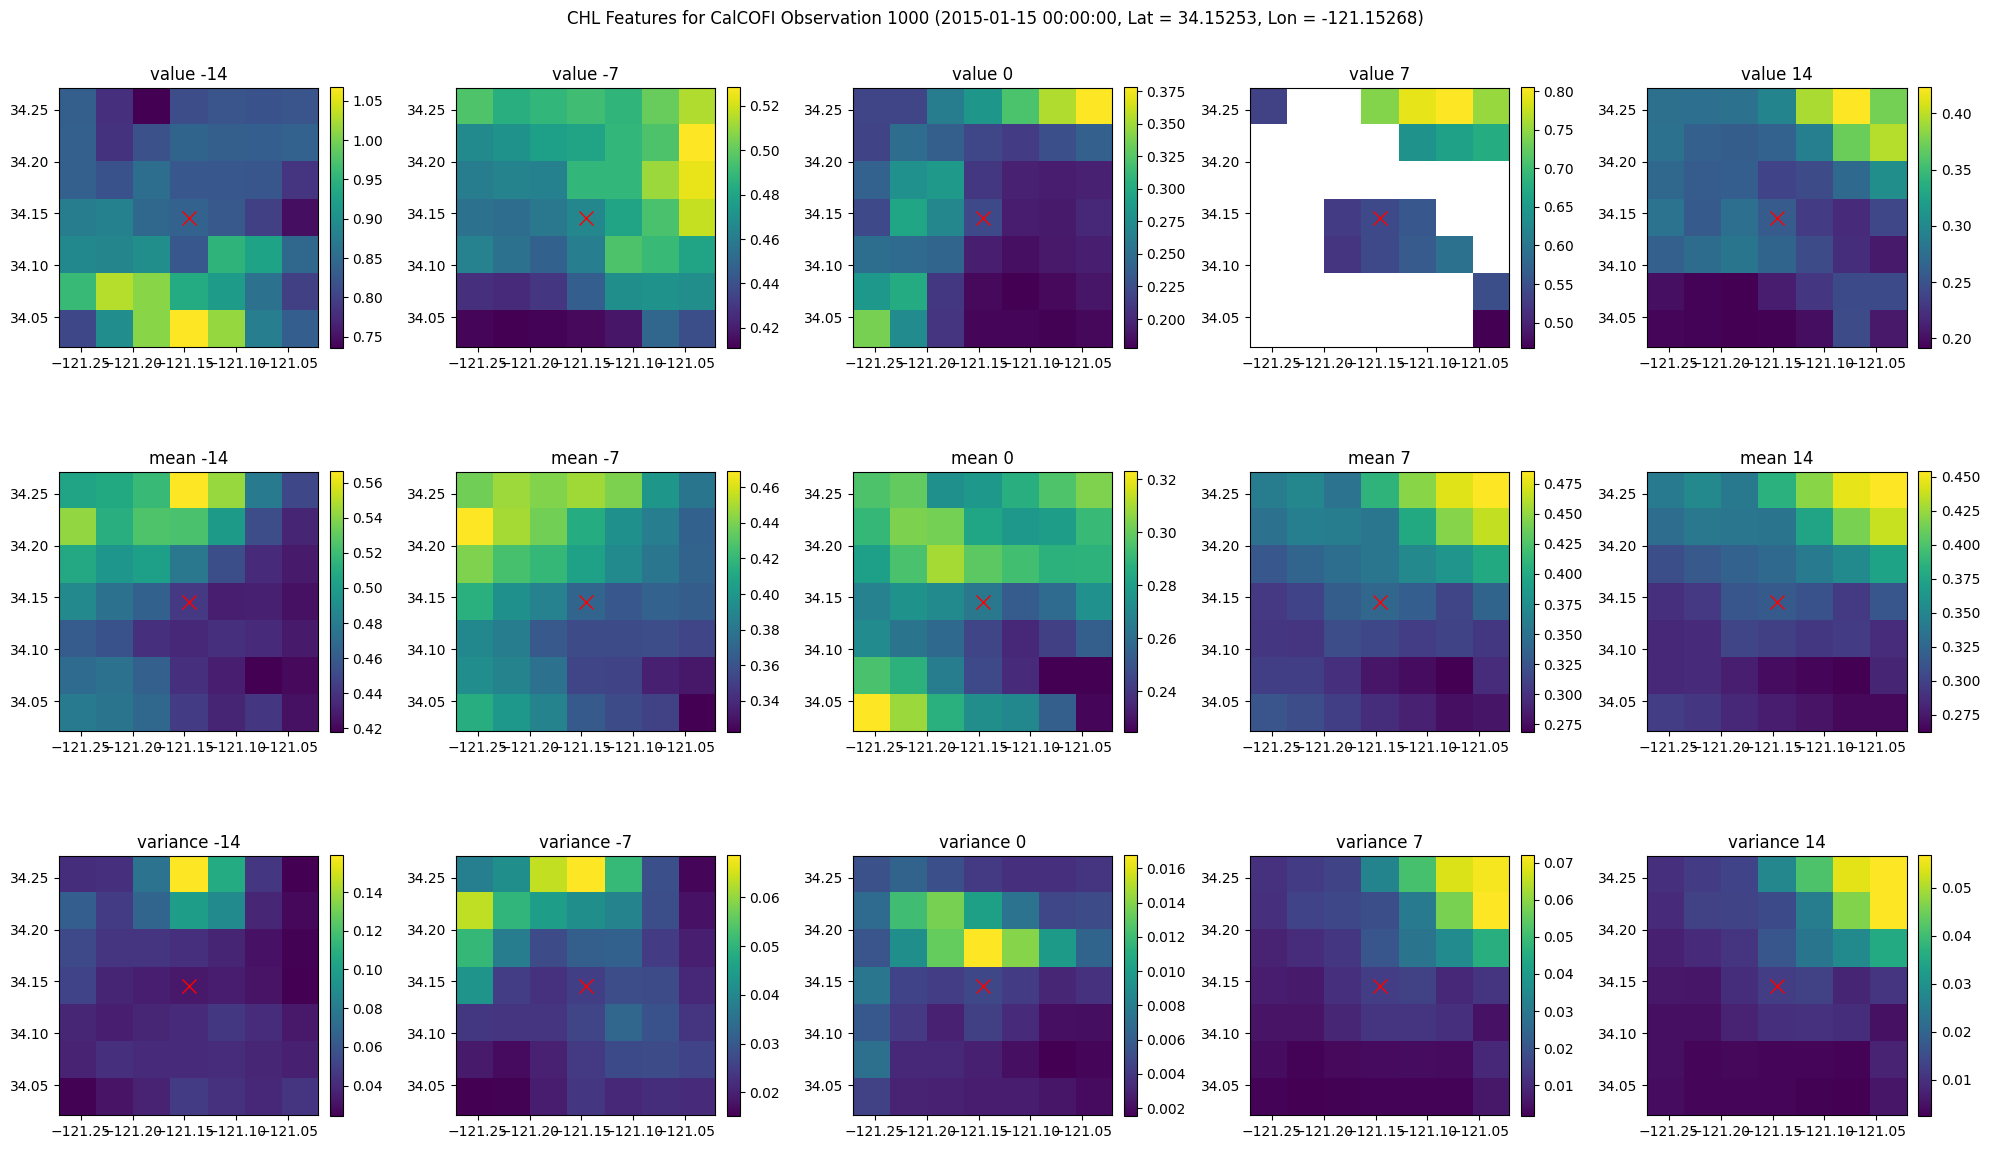

In [9]:
# Visualize features of one variable for one NPP observation

lags = [-14, -7, 0, 7, 14]
stats = ['value', 'mean', 'variance']

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12), sharex=False, sharey=False)
fig.suptitle(f'{var} Features for CalCOFI Observation {i} ({npp.loc[i, 'Date']}, Lat = {npp.loc[i, 'Latitude']}, Lon = {npp.loc[i, 'Longitude']})')

for i, stat in enumerate(stats):
    for j, lag in enumerate(lags):
        ax = axes[i, j]
        key = f'{var}_{stat}_{lag}'
        grid = features[key]
        
        # Convert to numpy array if xarray
        if hasattr(grid, 'values'):
            grid_data = grid.values
            lat = grid.latitude.values
            lon = grid.longitude.values
        else:
            grid_data = grid
            lat = np.arange(grid.shape[0])
            lon = np.arange(grid.shape[1])
        
        im = ax.imshow(grid_data, origin='lower', cmap='viridis',
                       extent=[lon[0], lon[-1], lat[0], lat[-1]])
        ax.set_title(f'{stat} {lag}')
        
        # Plot NPP observation as red X in center of grid
        lat_c = lat[len(lat)//2]
        lon_c = lon[len(lon)//2]
        ax.plot(lon_c, lat_c, 'rx', markersize=10)
        
        fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [ ]:
def process_var(var):

    lags = [-14, -7, 0, 7, 14]
    moving_window_stats = ['value', 'mean', 'variance']
    
    results_list = Parallel(n_jobs=-1, backend='threading')(
        delayed(extract_satellite_features)(i, var, min_valid_pixels)
        for i in tqdm(npp.index)
    )

    # convert results to xarray.Dataset
    data_vars = {}
    for stat in moving_window_stats:
        for lag in lags:
            arr = np.stack([res[f'{var}_{stat}_{lag}'] for res in results_list], axis=0)
            data_vars[f'{stat}_{lag}'] = (('npp', 'lat', 'lon'), arr)

    # Collect selected dates for each value lag
    selected_dates = {}
    for lag in lags:
        dates_arr = np.array(
            [res[f'date_{lag}'] if res[f'date_{lag}'] is not pd.NaT else np.datetime64('NaT') 
             for res in results_list],
            dtype='datetime64[ns]'
        )
        selected_dates[f'selected_date_{lag}'] = ('npp', dates_arr)

    # Find first valid xarray result to extract lat/lon coordinates
    ref = next(
        res[f'{var}_value_-14'] for res in results_list 
        if hasattr(res[f'{var}_value_-14'], 'latitude')
    )
    
    ds = xr.Dataset(
        data_vars=data_vars,
        coords={
            'npp': npp.index.values,
            'lat': ref.latitude.values,
            'lon': ref.longitude.values,
            'date': ('npp', npp['Date'].values),
            **selected_dates
        }
    )
    

    return ds

# Run for all variables
input_vars = ['CHL', 'PAR', 'SST', 'KD490', 'BBP', 'C', 'MLD', 'CHL:C', 'CDM', 'SPM', 
              'DIATO', 'DINO', 'GREEN', 'HAPTO', 'MICRO', 'NANO', 'PICO', 'PROCHLO', 'PROKAR', 
              'u10', 'v10', 'wind_stress_curl', 'no3', 
              'RRS412', 'RRS443', 'RRS490', 'RRS555', 'RRS670', 
              'ZSD', 'MESD']

for var in input_vars:
    print(var)
    try:
        var_ds = process_var(var)
        var_ds.to_netcdf(f'satellite_features/{var}.nc', engine='netcdf4')
    except Exception as e:
        print(f'ERROR processing {var}: {e}')
        continue

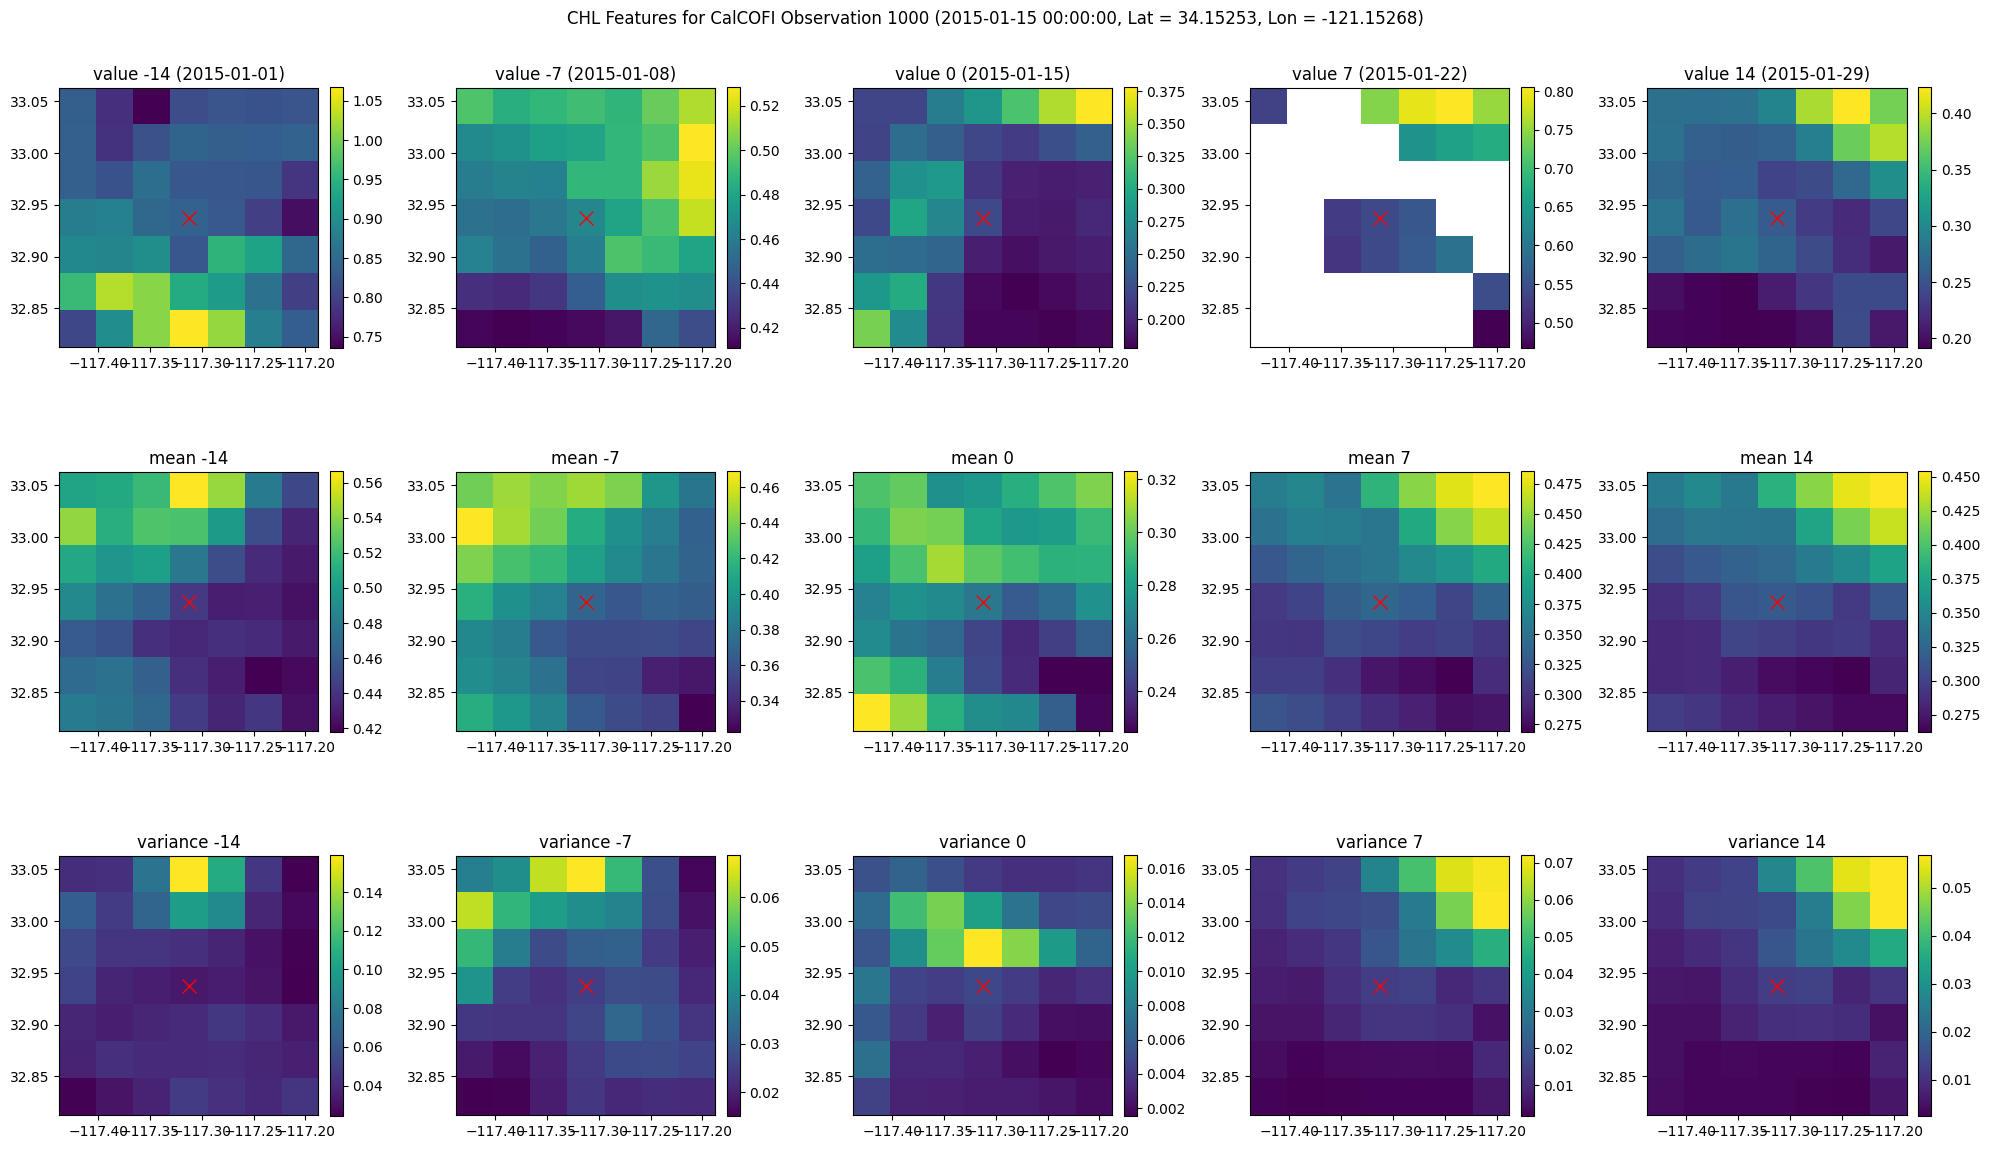

In [11]:
# Visualize features for an NPP observation and variable using var_ds.

obs_i = 1000  # change to whichever NPP observation you want
var = 'CHL'

lags = [-14, -7, 0, 7, 14]
stats = ['value', 'mean', 'variance']
var_ds = xr.open_dataset(f'satellite_features/{var}.nc')

lat = var_ds.lat.values
lon = var_ds.lon.values
lat_c = lat[len(lat) // 2]
lon_c = lon[len(lon) // 2]

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12), sharex=False, sharey=False)
fig.suptitle(f'{var} Features for CalCOFI Observation {obs_i} ({npp.loc[obs_i, "Date"]}, Lat = {npp.loc[obs_i, "Latitude"]}, Lon = {npp.loc[obs_i, "Longitude"]})')

for i, stat in enumerate(stats):
    for j, lag in enumerate(lags):
        ax = axes[i, j]
        grid_data = var_ds[f'{stat}_{lag}'].sel(npp=obs_i).values

        im = ax.imshow(grid_data, origin='lower', cmap='viridis',
                       extent=[lon[0], lon[-1], lat[0], lat[-1]])

        if stat == 'value':
            chosen_date = var_ds[f'selected_date_{lag}'].sel(npp=obs_i).values
            if pd.isnull(chosen_date):
                title = f'value {lag} (no valid date)'
            else:
                title = f'value {lag} ({pd.Timestamp(chosen_date).strftime("%Y-%m-%d")})'
        else:
            title = f'{stat} {lag}'

        
        ax.set_title(title)
        ax.plot(lon_c, lat_c, 'rx', markersize=10)
        fig.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()